In [7]:
from mxnet import gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt
from mxnet import autograd as autograd
from mxnet import nd
import mxnet as mx
from collections import namedtuple
import random

In [8]:
def transform(data,label):
    return data.astype('float32')/255,label.astype('float32')

In [10]:
fashion_train = gluon.data.vision.FashionMNIST(root='./',train=True,transform=transform)
fashion_test = gluon.data.vision.FashionMNIST(root='./',train=True, transform=transform)

In [18]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net):
    acc = 0.
    test_loss = 0.
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    for data, label in data_iterator:
        output = net(nd.transpose(data,(0,3,1,2)))
        loss = softmax_cross_entropy(output, label)
        acc += accuracy(output, label)
        test_loss +=nd.mean(loss).asscalar()
    return acc / len(data_iterator),test_loss / len(data_iterator)

In [12]:
def GetNN():
    net = nn.HybridSequential()
    with net.name_scope():
        net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        net.add(gluon.nn.Conv2D(channels=50, kernel_size=3, activation='relu'))
        net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
        net.add(gluon.nn.Flatten())
        net.add(gluon.nn.Dense(10))
        
        
        fc21 = nn.Dense(fc1)
        fc22 = nn.Dense(fc1)
        net.add(nd.concat(fc21,fc22,dim=1))
        
        
        
    net.initialize(init=mx.init.Xavier())
    net.hybridize()
    return net

In [90]:
def NN_Train(net, train_data, test_data, epochs, batch_size, learning_rate, weight_decay):
    msg=''
    train_loss = []
    train_acc = []
    dataset_train = gluon.data.DataLoader(train_data,batch_size,shuffle=True)
    test_loss = []
    test_acc = []
    dataset_test = gluon.data.DataLoader(test_data,batch_size,shuffle=True)
        
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': learning_rate,
                             'wd': weight_decay})
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    
    for epoch in range(epochs):
        _loss = 0.
        _acc = 0.
        t_acc = 0.
        for data, label in dataset_train:
            data = nd.transpose(data,(0,3,1,2))
            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(batch_size)

            _loss += nd.mean(loss).asscalar()
            _acc += accuracy(output, label)
        __acc = _acc / len(dataset_train) 
        __loss = _loss / len(dataset_train)
        train_loss.append(__loss)
        train_acc.append(__acc)
        
        t_acc,t_loss = evaluate_accuracy(dataset_test, net)
        test_loss.append(t_loss)
        test_acc.append(t_acc)
            
        msg += ("Epoch %d. Train Loss: %f, Test Loss: %f, Train acc %f, Test acc %f\n" % (
            epoch, __loss, t_loss,__acc, t_acc))
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(train_loss,'r')
    ax1.plot(test_loss,'g')
    ax1.legend(['Train_Loss','Test_Loss'],loc=2)
    ax1.set_ylabel('Loss')

    ax2 = ax1.twinx()
    ax2.plot(train_acc,'b')
    ax2.plot(test_acc,'y')
    ax2.legend(['Train_Acc','Test_Acc'],loc=1)
    ax2.set_ylabel('Acc')
    
    plt.savefig('1.png',dpi=600)
    plt.show()
    net.collect_params().save('NN.params')
    return msg

In [29]:
epochs = 3
learning_rate = 0.008
batch_size = 128
weight_decay = 0.

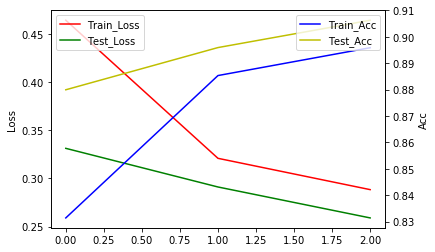

Epoch 0. Train Loss: 0.464664, Test Loss: 0.331341, Train acc 0.831412, Test acc 0.879947
Epoch 1. Train Loss: 0.320958, Test Loss: 0.291131, Train acc 0.885333, Test acc 0.895933
Epoch 2. Train Loss: 0.288373, Test Loss: 0.258940, Train acc 0.895878, Test acc 0.906283



In [91]:
msg = NN_Train(
    net=GetNN(),
    train_data=fashion_train,
    test_data=fashion_test,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay)
print(msg)